# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [7]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, height=8, width=8):
        # Set information about the gridworld (default 8x8, but flexible now)
        self.height = height
        self.width = width
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent (middle row, random column)
        self.current_location = (self.height // 2, np.random.randint(0, self.width))

        # Set locations for the bomb and the gold
        # (keep them near the top, but ensure valid positions)
        self.bomb_location = (1, min(3, self.width - 1))
        self.gold_location = (0, min(3, self.width - 1))
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    ## Methods stay the same (no change needed)...
    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location

        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0] - 1, last_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0] + 1, last_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0], last_location[1] - 1)
                reward = self.get_reward(self.current_location)

        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0], last_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'


In [3]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [5]:
class Q_Agent():
    # Initialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()  # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height):  # Loop through all possible grid spaces
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            # Exploration
            action = np.random.choice(available_actions)
        else:
            # Exploitation: pick best action(s)
            state = self.environment.current_location
            q_values = self.q_table[state]
            max_q = max(q_values[a] for a in available_actions)
            # Random tie-break if multiple best
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            action = np.random.choice(best_actions)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Q-learning update"""
        old_q = self.q_table[old_state][action]
        # If terminal state, no future Q
        if new_state in self.environment.terminal_states:
            target = reward
        else:
            max_future_q = max(self.q_table[new_state].values())
            target = reward + self.gamma * max_future_q

        # Q update
        self.q_table[old_state][action] = old_q + self.alpha * (target - old_q)

In [6]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
# Larger world (20x20)
env_medium = GridWorld(height=20, width=20)

# Even larger (50x50)
env_large = GridWorld(height=50, width=50)

agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

In [8]:
# Define environments of different sizes
env_small = GridWorld(height=8, width=8)
env_medium = GridWorld(height=20, width=20)
env_large = GridWorld(height=50, width=50)

agent = RandomAgent()

# Put environments in a list so we can loop
environments = [("Small (8x8)", env_small),
                ("Medium (20x20)", env_medium),
                ("Large (50x50)", env_large)]

# Run the same process for each environment
for name, env in environments:
    print("\n--- Testing", name, "GridWorld ---")
    print("Current position of the agent =", env.current_location)
    print(env.agent_on_map())

    available_actions = env.get_available_actions()
    print("Available_actions =", available_actions)

    chosen_action = agent.choose_action(available_actions)
    print("Randomly chosen action =", chosen_action)

    reward = env.make_step(chosen_action)
    print("Reward obtained =", reward)

    print("New position of the agent =", env.current_location)
    print(env.agent_on_map())



--- Testing Small (8x8) GridWorld ---
Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
New position of the agent = (5, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

--- Testing Medium (20x20) GridWorld ---
Current position of the agent = (10, 0)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 

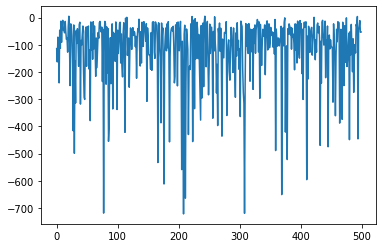

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

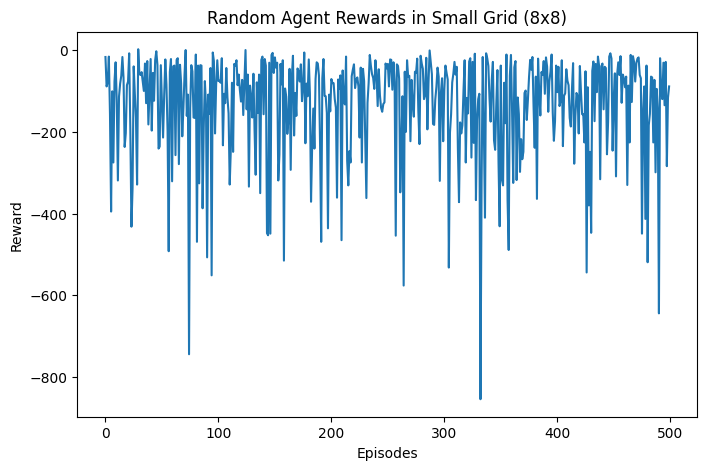

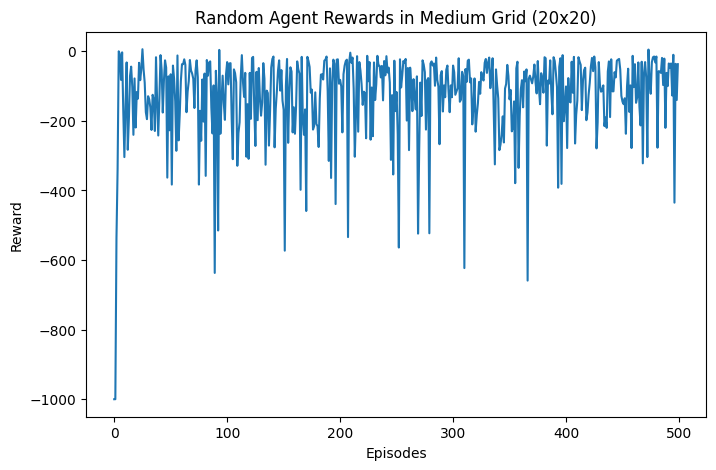

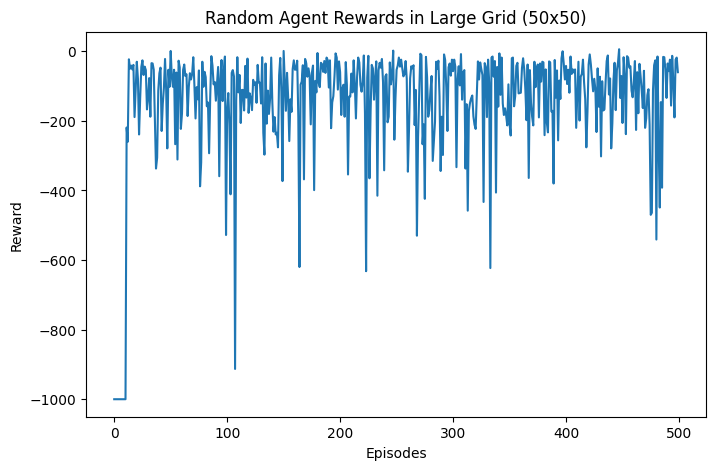

In [10]:
# Initialize environments
env_small = GridWorld(height=8, width=8)
env_medium = GridWorld(height=20, width=20)
env_large = GridWorld(height=50, width=50)

# Random agent
random_agent = RandomAgent()

# Run experiments
reward_small = play(env_small, random_agent, trials=500)
reward_medium = play(env_medium, random_agent, trials=500)
reward_large = play(env_large, random_agent, trials=500)

# --- Plot Small (8x8) ---
plt.figure(figsize=(8,5))
plt.plot(reward_small)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Random Agent Rewards in Small Grid (8x8)")
plt.show()

# --- Plot Medium (20x20) ---
plt.figure(figsize=(8,5))
plt.plot(reward_medium)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Random Agent Rewards in Medium Grid (20x20)")
plt.show()

# --- Plot Large (50x50) ---
plt.figure(figsize=(8,5))
plt.plot(reward_large)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Random Agent Rewards in Large Grid (50x50)")
plt.show()


## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

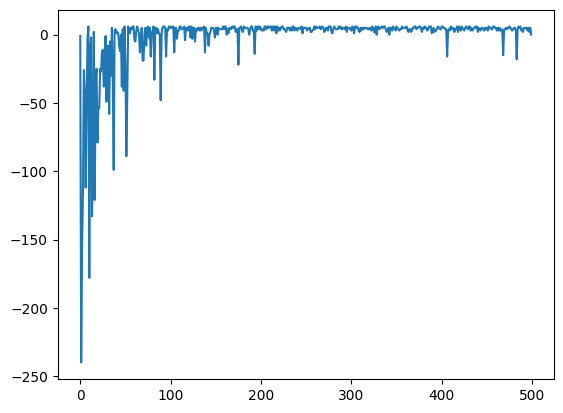

In [14]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

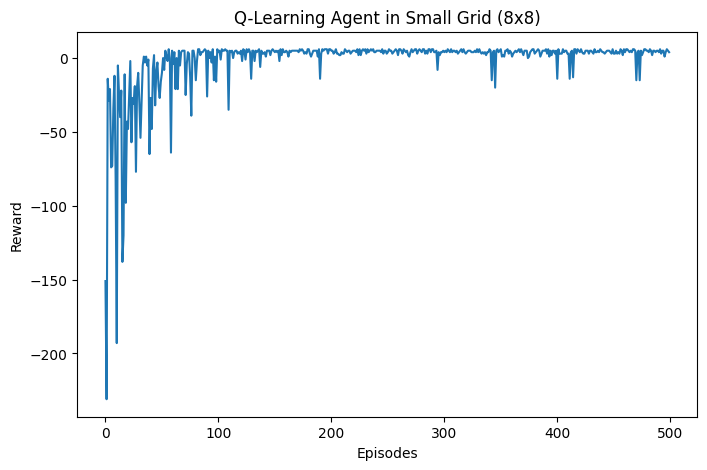

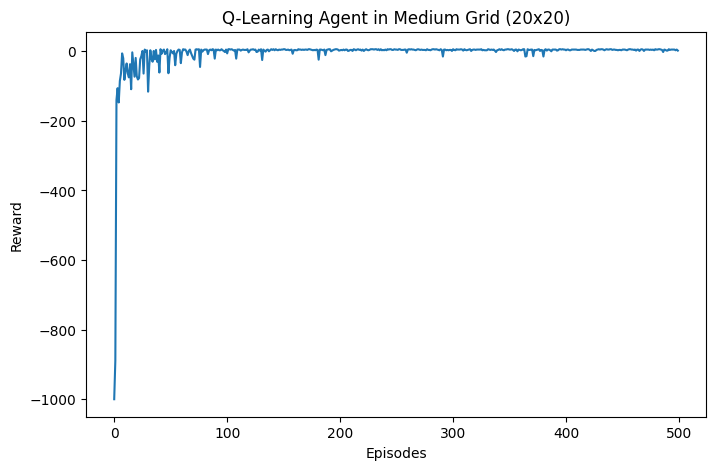

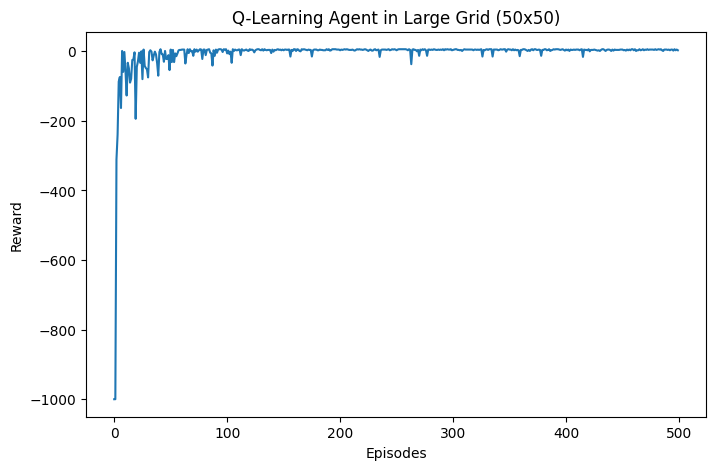

In [15]:
# --- Small Grid (8x8) ---
env_small = GridWorld(height=8, width=8)
agent_small = Q_Agent(env_small)
reward_small = play(env_small, agent_small, trials=500, learn=True)

plt.figure(figsize=(8,5))
plt.plot(reward_small)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Q-Learning Agent in Small Grid (8x8)")
plt.show()

# --- Medium Grid (20x20) ---
env_medium = GridWorld(height=20, width=20)
agent_medium = Q_Agent(env_medium)
reward_medium = play(env_medium, agent_medium, trials=500, learn=True)

plt.figure(figsize=(8,5))
plt.plot(reward_medium)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Q-Learning Agent in Medium Grid (20x20)")
plt.show()

# --- Large Grid (50x50) ---
env_large = GridWorld(height=50, width=50)
agent_large = Q_Agent(env_large)
reward_large = play(env_large, agent_large, trials=500, learn=True)

plt.figure(figsize=(8,5))
plt.plot(reward_large)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Q-Learning Agent in Large Grid (50x50)")
plt.show()


Print the final Q-value table with nice formatting.

In [16]:
def pretty(d, indent=0):
    for key, value in d.items():
        # Print the state key (like (x,y))
        print('\t' * indent + str(key))

        # If the value is another dictionary (the actions for this state)
        if isinstance(value, dict):
            pretty(value, indent+1)   # recursively print inner dict with more indentation
        else:
            # Otherwise just print the value (the Q-value)
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		-0.35290000000000005
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		1.4812253238991715
(0, 2)
	UP
		4.036280892738917
	DOWN
		4.067241225687047
	LEFT
		-0.13441865828329003
	RIGHT
		9.99999999998973
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		1.6288566587349456
	DOWN
		3.1304872643764545
	LEFT
		9.999999999667697
	RIGHT
		1.07992519338271
(0, 5)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		7.217632341820957
	RIGHT
		-0.1
(0, 6)
	UP
		-0.38485100000000005
	DOWN
		-0.3099
	LEFT
		0.812256093717088
	RIGHT
		-0.30000000000000004
(0, 7)
	UP
		-0.5
	DOWN
		-0.52
	LEFT
		-0.5148838376926279
	RIGHT
		-0.6
(1, 0)
	UP
		-0.47100000000000003
	DOWN
		-0.5531783841302151
	LEFT
		-0.5
	RIGHT
		-0.25891463278966154
(1, 1)
	UP
		-0.29000000000000004
	DOWN
		-0.45375218182715416
	LEFT
		-0.41703463164000004
	RIGHT
		3.172283467708752
(1, 2)
	UP
		8.99999999978021
	DOWN
		2.782596901205503
	LEFT


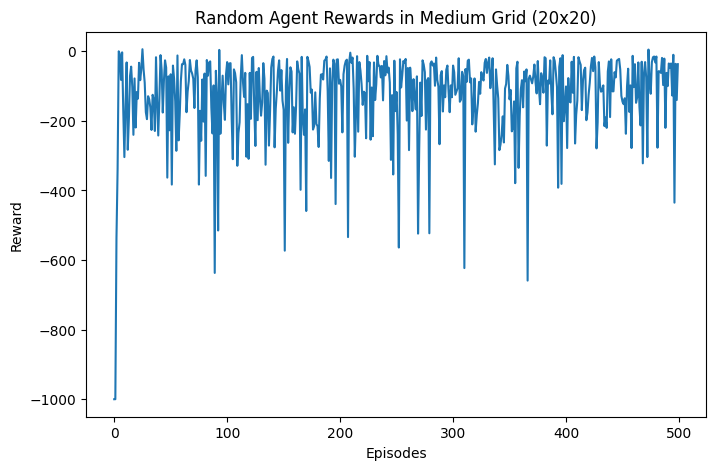
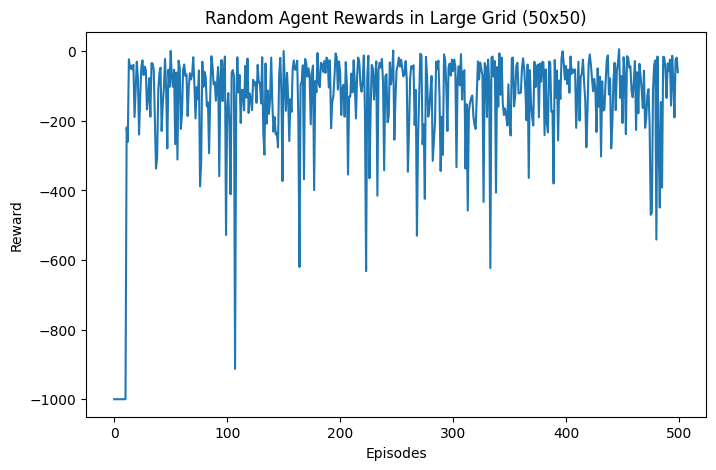

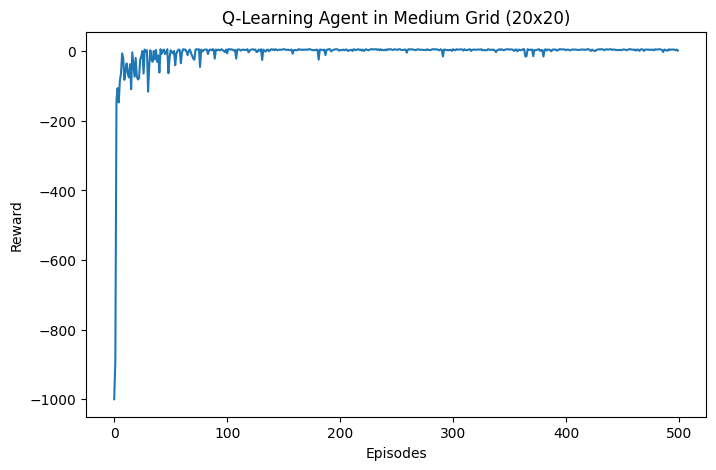
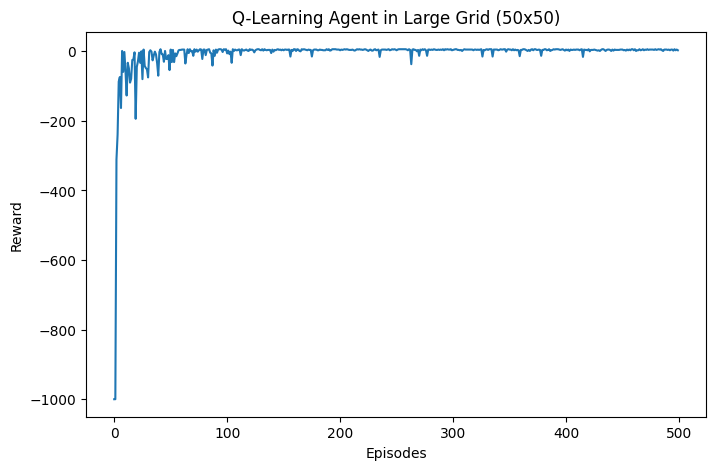